In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
import time
import random
import pickle as pkl
from scipy.stats import gamma, poisson, linregress, beta, norm, lognorm
from cratersfd import *
%matplotlib inline

mpl.rcParams['font.family'] = 'Helvetica'

In [2]:
latitude_factor = np.cos(math.pi * (26 + 11 / 60) / 180)
pixel_factor = 0.626608880720610
cfactor = latitude_factor * pixel_factor
rawd = pd.read_csv(
    '../data/M146959973L.txt', delimiter='\t'
) * cfactor
ds = np.array(sorted(rawd['D_wm'].tolist())) / 1000
w = 4000 * cfactor / 1000
h = 2215 * cfactor / 1000
area = h * w

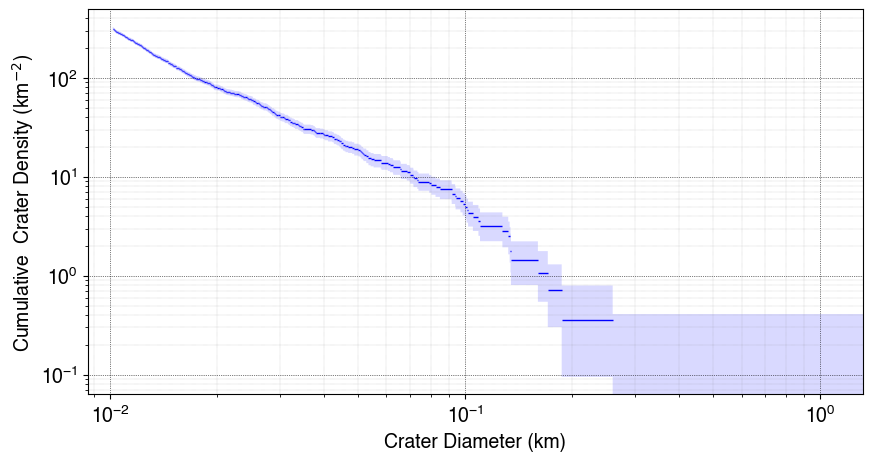

In [3]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plot_cumulative_unbinned(ds, area, color='blue')

0.09

<Figure size 640x480 with 0 Axes>

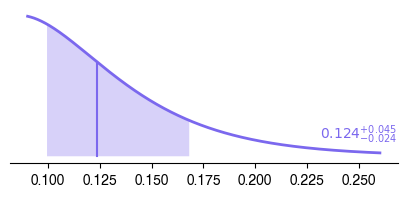

In [4]:
visual_dmin = 0.09
dmin = 0.11
dmin_rv = apply_factor(dmin, 1.5)
dmin_rv = dmin_rv.slice(
    visual_dmin, np.max(ds)
).normalize().as_kind('median')
dmin_rv.plot(label=True)
visual_dmin

<Figure size 640x480 with 0 Axes>

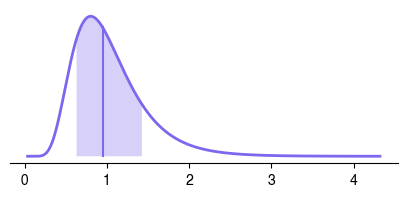

In [5]:
d_ncf_npf_error = apply_factor(1, 1 + npf_error(0.5))
dmin_npf_error = apply_factor(1, 1 + npf_error(dmin_rv.mean()))
pf_error = (dmin_npf_error / d_ncf_npf_error).trim()
pf_error.plot()

In [6]:
d_systematic_std = 0.07
d_error = apply_factor(1, 1 + d_systematic_std)
lambda_error = apply_factor(1, 1.5)

dmin_rv_list = split_by_N(dmin_rv, ds)

dmin_rvs_d_error = [
    li[1] * d_error
    for li in dmin_rv_list
]

N1_rv_list = [
    [li[0], N1_pdf(
        li[0], area, li[1], kind='median', 
        d_error=d_error
    ), li[2]]
    for li in dmin_rv_list
]

X_list = [rvi[1].X for rvi in N1_rv_list]
Xmin = np.min([Xi.min() for Xi in X_list])
Xmax = np.max([Xi.max() for Xi in X_list])
Xlen = np.max([Xi.shape[0] for Xi in X_list])
N1X = np.linspace(Xmin, Xmax, Xlen, endpoint=True)

N1_P_array = np.array([
    li[1].match_X(N1X).P * li[2]
    for li in N1_rv_list
])

summed_N1_rv = RandomVariable(
    N1X, np.sum(N1_P_array, axis=0), kind='median'
)

final_age_rv = summed_N1_rv.apply(ncf_inv)

In [7]:
t1 = time.time()
N1_rv_list_pf_error = [
    [li[0], N1_pdf(
        li[0], area, li[1], kind='median', 
        d_error=d_error, lambda_error=lambda_error,
        pf_error=pf_error
    ), li[2]]
    for li in dmin_rv_list
]

X_list = [rvi[1].X for rvi in N1_rv_list_pf_error]
Xmin = np.min([Xi.min() for Xi in X_list])
Xmax = np.max([Xi.max() for Xi in X_list])
Xlen = np.max([Xi.shape[0] for Xi in X_list])
N1X = np.linspace(Xmin, Xmax, Xlen, endpoint=True)

N1_P_array = np.array([
    li[1].match_X(N1X).P * li[2]
    for li in N1_rv_list_pf_error
])

summed_N1_rv_pf_error = RandomVariable(
    N1X, np.sum(N1_P_array, axis=0), kind='median'
)

final_age_rv_pf_error = summed_N1_rv_pf_error.apply(ncf_inv)
t2 = time.time()
print(format_runtime(t2 - t1))

17.46298 seconds


<Figure size 640x480 with 0 Axes>

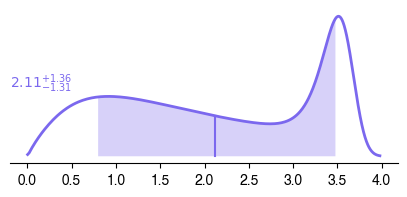

In [8]:
final_age_rv_pf_error.plot(label=True)

16.95506 seconds


<Figure size 640x480 with 0 Axes>

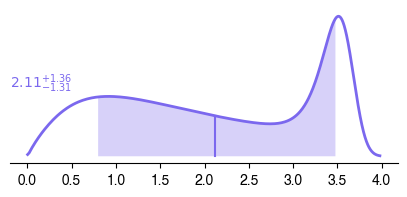

In [9]:
t1 = time.time()
age_rv = age_pdf(
    ds, area, dmin_rv, d_error=d_error,
    lambda_error=lambda_error, pf_error=pf_error,
    kind='median'
)
t2 = time.time()
print(format_runtime(t2 - t1))

age_rv.plot(label=True)

/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_73633/1933778475.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


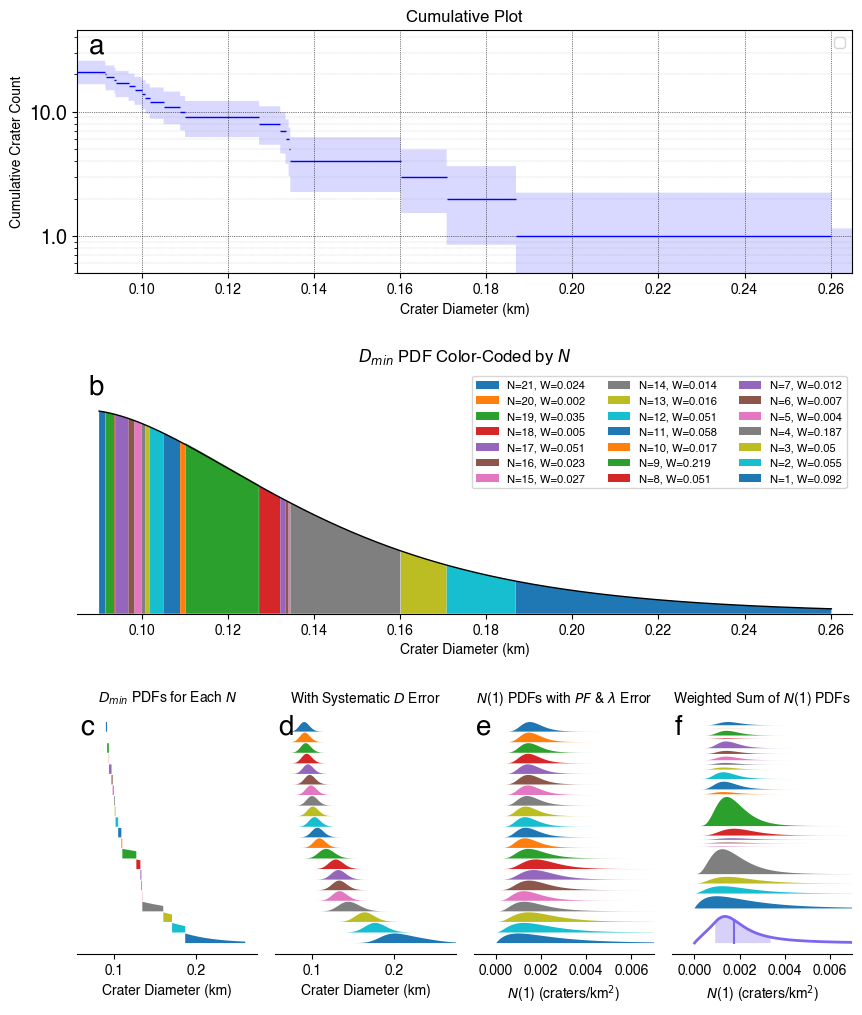

In [10]:
xlim = [0.085, 0.265] # np.max(ds)]
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(3, 4, figure=fig)

ax = plt.subplot(gs[0, :])
plot_cumulative_unbinned(ds, 1.0, color='blue', kind='log')
plt.xlim(xlim)
plt.ylim([0.5, 45.5])
plt.xscale('linear')
plt.xlabel('Crater Diameter (km)', size=10)
plt.ylabel('Cumulative Crater Count', size=10)
plt.xticks(size=10)
# plt.yticks(np.arange(10, 22), size=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
d = np.linspace(xlim[0], xlim[1], 10000)
# plt.plot(
#     d, final_age_rv.mean() * npf_new(d) * area, 'k', lw=0.7,
#     label='NPF fit at mean of summed PDF'
# )
plt.legend()
plt.title(rf'Cumulative Plot', size=12)
plt.text(
    0.015, 0.985, 'a', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = plt.subplot(gs[1, :])
Pmax = np.max([li[1].P.max() * li[2] for li in dmin_rv_list])
for li in dmin_rv_list:
    plt.fill_between(
        li[1].X, li[1].P * li[2] / Pmax, 
        label='N=' + str(li[0]) + ', W=' + str(round(li[2], 3))
    )
plt.plot(dmin_rv.X, dmin_rv.P / dmin_rv.P.max(), 'k', lw=1)
plt.xlim(xlim)
plt.ylim([0, 1.2])
plt.xticks(size=10)
plt.xlabel('Crater Diameter (km)', size=10)
erase_box(ax)
plt.legend(ncols=3, fontsize=8)
plt.title(rf'$D_{{min}}$ PDF Color-Coded by $N$', size=12)
plt.text(
    0.015, 0.985, 'b', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = plt.subplot(gs[2, 0])
upshift = 0
for li in dmin_rv_list:
    plt.fill_between(
        li[1].X, li[1].P / li[1].P.max() + upshift, upshift
    )
    upshift -= 1.1
plt.xticks(size=10)
plt.xlabel('Crater Diameter (km)', size=10)
plt.xlim([0.055, 0.275])
erase_box(ax)
plt.title(rf'$D_{{min}}$ PDFs for Each $N$', size=10)
plt.text(
    0.015, 0.985, 'c', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = plt.subplot(gs[2, 1])
upshift = 0
for rv in dmin_rvs_d_error:
    plt.fill_between(
        rv.X, rv.P / rv.P.max() + upshift, upshift
    )
    upshift -= 1.1
plt.xticks(size=10)
plt.xlabel('Crater Diameter (km)', size=10)
plt.xlim([0.055, 0.275])
erase_box(ax)
plt.title(rf'With Systematic $D$ Error', size=10)
plt.text(
    0.015, 0.985, 'd', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = plt.subplot(gs[2, 2])
upshift = 0
for li in N1_rv_list:
    plt.fill_between(
        li[1].X, li[1].P / li[1].P.max() + upshift, upshift
    )
    upshift -= 1.1
plt.xticks(size=10)
plt.xlabel(rf'$N$(1) (craters/km$^2$)', size=10)
plt.xlim([-0.001, 0.007])
erase_box(ax)
plt.title(rf'$N$(1) PDFs with $PF$ & $\lambda$ Error', size=10)
plt.text(
    0.015, 0.985, 'e', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = plt.subplot(gs[2, 3])
upshift = 0
for li in N1_rv_list:
    plt.fill_between(
        li[1].X, 
        5 * li[2] * (li[1].P / li[1].P.max() - 1) + upshift, 
        upshift - 5 * li[2]
    )
    upshift -= 5 * np.max(li[1].P / li[1].P.max() * li[2]) + 0.1
upshift -= 1.2
summed_N1_rv.plot(upshift=upshift)
plt.xlim([-0.001, 0.007])
# plt.ylim([upshift, 0])
plt.xticks(size=10)
plt.xlabel(rf'$N$(1) (craters/km$^2$)', size=10)
erase_box(ax)
plt.title(rf'Weighted Sum of $N$(1) PDFs', size=10)
plt.text(
    0.015, 0.985, 'f', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

fig.subplots_adjust(hspace=0.4, wspace=0.1)
plt.gcf().savefig(
    'figs/dminPDF.pdf', bbox_inches='tight'
)

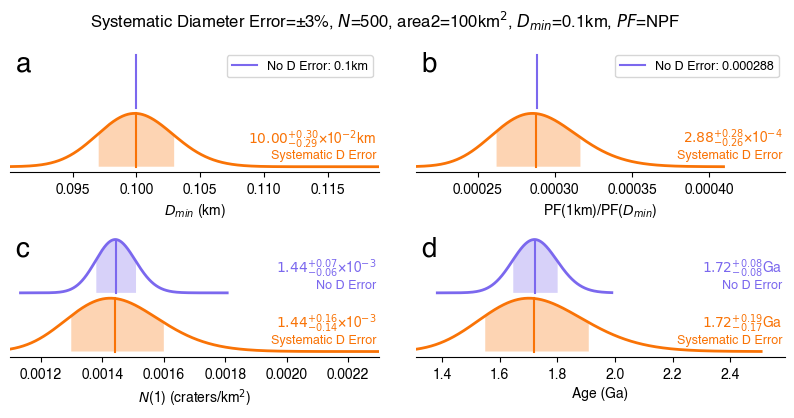

In [11]:
dmin = 0.1
N = 500
area2 = 100
d_systematic_std = 0.03
pf = npf_new

d_error = apply_factor(1, 1 + d_systematic_std)
dmin_rv = dmin * d_error
N1_shift = pf(1) / pf(dmin)
N1_shift_rv = pf(1) / dmin_rv.apply(pf).as_kind('median')

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(221)
dmin_rv.plot(
    color=cs[4], xlim=[0.0901, 0.119], label=True,
    pdf_label='Systematic D Error', unit='km',
    label_shift_y=0.07
)
plt.plot(
    [dmin, dmin], [1.1, 2.1], 'mediumslateblue',
    label='No D Error: ' + str(dmin) + 'km'
)
plt.legend(fontsize=9)
plt.xlabel(rf'$D_{{min}}$ (km)')
erase_box(ax)
plt.text(
    0.015, 0.985, 'a', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = fig.add_subplot(222)
xlim = [0.00021, 0.000449]
N1_shift_rv.plot(
    label=True, color=cs[4], xlim=xlim,
    pdf_label='Systematic D Error',
    label_shift_y=0.07
)
plt.plot(
    [N1_shift, N1_shift], [1.1, 2.1], 'mediumslateblue',
    label='No D Error: ' + str(round(N1_shift, 6))
)
plt.legend(fontsize=9)
plt.xlabel(rf'PF(1km)/PF($D_{{min}}$)')
erase_box(ax)
plt.text(
    0.015, 0.985, 'b', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = fig.add_subplot(223)
xlim = [0.0011, 0.0023]
N1_rv = N1_pdf(N, area2, dmin, kind='median')
N1_rv_d_error = N1_pdf(
    N, area2, dmin, d_error=d_error, kind='median')
N1_rv_d_error.plot(
    label=True, color=cs[4], xlim=xlim,
    pdf_label='Systematic D Error',
    label_shift_y=0.07
)
N1_rv.plot(
    label=True, xlim=xlim, upshift=1.1, 
    pdf_label='No D Error'
)
plt.xlabel(rf'$N$(1) (craters/km$^2$)')
erase_box(ax)
plt.text(
    0.015, 0.985, 'c', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

ax = fig.add_subplot(224)
xlim = [1.31, 2.59]
age_rv = age_pdf(N, area2, dmin, kind='median')
age_rv_d_error = age_pdf(
    N, area2, dmin, d_error=d_error, kind='median'
)
age_rv_d_error.plot(
    label=True, color=cs[4], xlim=xlim,
    pdf_label='Systematic D Error', unit='Ga',
    label_shift_y=0.07
)
age_rv.plot(
    label=True, xlim=xlim, upshift=1.1, 
    pdf_label='No D Error', unit='Ga'
)
plt.xlabel('Age (Ga)')
erase_box(ax)
plt.text(
    0.015, 0.985, 'd', 
    transform=plt.gca().transAxes, 
    ha='left', va='top', size=20
)

fig.suptitle(
    'Systematic Diameter Error=±3%, '
    rf'$N$=' + str(N) + ', area2=' + str(area2) + rf'km$^2$, $D_{{min}}$=0.1km'
    rf', $PF$=NPF'
)

fig.subplots_adjust(hspace=0.5, wspace=0.1)

plt.gcf().savefig('figs/systematic_D_error.pdf', bbox_inches='tight')